In [20]:
from config import DATABASE_URI
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
from PIL import Image
import io
import psycopg2

In [21]:
def get_images_from_db():
    
    conn = psycopg2.connect(DATABASE_URI)
    
    cursor = conn.cursor()
    cursor.execute("SELECT fruit_name, image FROM fruits")
    rows = cursor.fetchall()
    images, labels = [], []
    
    for row in rows:
        fruit_name, binary_data = row
        image = Image.open(io.BytesIO(binary_data)).convert('RGB')
        image = image.resize((128, 128))
        images.append(np.array(image))
        labels.append(fruit_name)
    cursor.close()
    conn.close()
    return np.array(images), np.array(labels)

images, labels = get_images_from_db()
print(f'Retrieved {len(images)} images from the database.')

Retrieved 9678 images from the database.


In [22]:
# Normalize the images
images = images / 255.0

# Encode labels as integers
label_encoder = LabelEncoder()

labels = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [23]:
# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\Javier Alarcon\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,973 (12.47 MB)

 Trainable params: 3,267,973 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - accuracy: 0.3969 - loss: 1.4536 - val_accuracy: 0.5165 - val_loss: 1.1684
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.5454 - loss: 1.0795 - val_accuracy: 0.5733 - val_loss: 1.0336
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.6046 - loss: 0.9706 - val_accuracy: 0.5956 - val_loss: 0.9854
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.6543 - loss: 0.8651 - val_accuracy: 0.5806 - val_loss: 1.0320
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.7268 - loss: 0.7017 - val_accuracy: 0.6028 - val_loss: 1.0527
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.8107 - loss: 0.5076 - val_accuracy: 0.6209 - val_loss: 1.1206
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.8981 - loss: 0.3041 - val_accuracy: 0.5992 - val_loss: 1.4224
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.9349 - loss: 0

In [25]:
# Save the model
model.save('NeuralNetwork_train_model/fruit_classifier_model.h5')

In [26]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

61/61 - 2s - 29ms/step - accuracy: 0.6126 - loss: 2.2813
Test accuracy: 0.6126033067703247


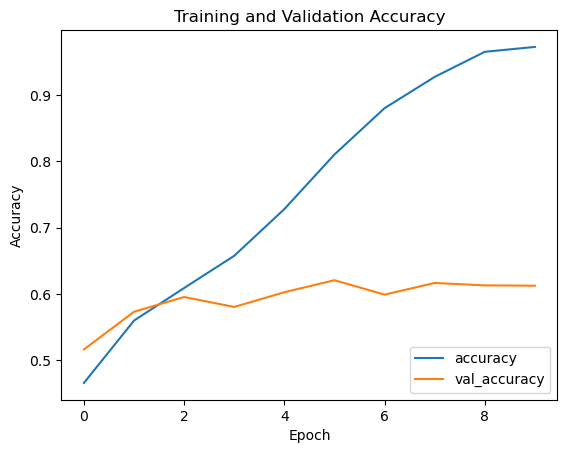

In [28]:
# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('Accuracy_Epoch_Graph_images/model_1')
plt.show()

In [ ]:
# Predict on test data
predictions = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

In [ ]:
# Print some of the predictions to see how the model performs
for i in range(50):
    print(f'Actual: {label_encoder.inverse_transform([y_test[i]])[0]}, Predicted: {predicted_labels[i]}')

In [ ]:
# Save the label encoder
import pickle

with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [ ]:
model_2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_2.summary()


In [ ]:
# Train the model
history_2 = model_2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

In [ ]:
# Save the model
model_2.save('NeuralNetwork_train_model/fruit_classifier_model_2.h5')

In [ ]:
# Evaluate the model
test_loss, test_acc = model_2.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

In [ ]:
# Build and compile the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)
model_3 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:

# Train the model
history_3 = model_3.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))



In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

In [ ]:
# Save the model
model.save('fruit_classifier_mobilenetv2.h5')